In [4]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec
import pandas as pd
import re


In [5]:
messages = [line.rstrip() for line in open('smsspamCollection/SMSSpamCollection')]
print(len(messages))


5574


In [6]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [9]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

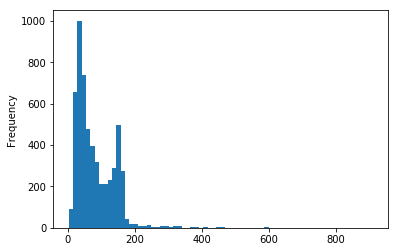

In [12]:
messages['length'].plot(bins=70, kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000021FB55D8C88>,
      dtype=object)

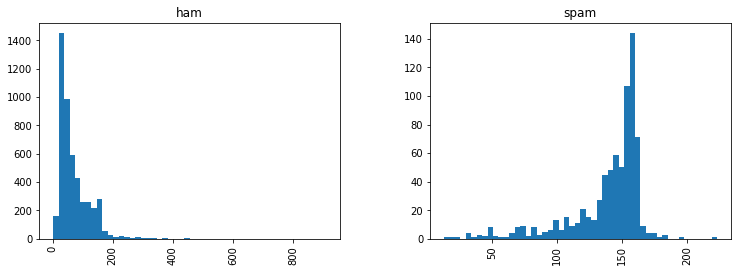

In [13]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

In [14]:
def text_process(messages):
    nopunc = [char for char in messages if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
print(messages)

     label                                            message  length
0      ham  Go until jurong point, crazy.. Available only ...     111
1      ham                      Ok lar... Joking wif u oni...      29
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3      ham  U dun say so early hor... U c already then say...      49
4      ham  Nah I don't think he goes to usf, he lives aro...      61
5     spam  FreeMsg Hey there darling it's been 3 week's n...     147
6      ham  Even my brother is not like to speak with me. ...      77
7      ham  As per your request 'Melle Melle (Oru Minnamin...     160
8     spam  WINNER!! As a valued network customer you have...     157
9     spam  Had your mobile 11 months or more? U R entitle...     154
10     ham  I'm gonna be home soon and i don't want to tal...     109
11    spam  SIX chances to win CASH! From 100 to 20,000 po...     136
12    spam  URGENT! You have won a 1 week FREE membership ...     155
13     ham  I've bee

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11425


In [19]:
messages_bow = bow_transformer.transform(messages['message'])
messages_bow

<5572x11425 sparse matrix of type '<class 'numpy.int64'>'
	with 50548 stored elements in Compressed Sparse Row format>

In [18]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(messages_bow)
print(tfidf4)

  (0, 11163)	0.23026685592418913
  (0, 10965)	0.19073428545061483
  (0, 8917)	0.24704652376837993
  (0, 8336)	0.17046869292195632
  (0, 7668)	0.26403384065473806
  (0, 7555)	0.31253856260694546
  (0, 6937)	0.1834692413608692
  (0, 6906)	0.15158474664662352
  (0, 6217)	0.18915557732842803
  (0, 5769)	0.24984711892976424
  (0, 5218)	0.26870593862526665
  (0, 5217)	0.29835184088197164
  (0, 4653)	0.31253856260694546
  (0, 2060)	0.24203960256420656
  (0, 1483)	0.31253856260694546
  (0, 1110)	0.2882862016308418
  (1, 11072)	0.40061560982443056
  (1, 10698)	0.2063637481323008
  (1, 8590)	0.5043405901305854
  (1, 7701)	0.3767401070812794
  (1, 3064)	0.2911995411244838
  (1, 2451)	0.561988811929381
  (2, 11123)	0.19104387220509106
  (2, 11084)	0.15898145347176754
  (2, 10686)	0.13995540820792943
  :	:
  (5568, 6882)	0.31367469776242124
  (5568, 6691)	0.47781076401785183
  (5568, 6354)	0.5575721048646767
  (5568, 4880)	0.3853122086093004
  (5569, 10199)	0.520467167163554
  (5569, 8252)	0.432829

In [25]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_bow, messages['label'])

In [26]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


In [22]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


In [27]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()), 
])

In [28]:
pipeline.fit(msg_train,label_train)


Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x0000021FB562DD90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [29]:
predictions = pipeline.predict(msg_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98      1004
        spam       0.71      1.00      0.83       111

   micro avg       0.96      0.96      0.96      1115
   macro avg       0.86      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

